In [1]:
# Import all the required libraries
from pandas._libs.tslibs.timestamps import Timestamp
from timeseries_generator import Generator, SinusoidalFactor, WhiteNoise
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta, datetime

import pandas as pd

In [2]:
# Configure the parmeters

resolution = 5 #in minutes
no_of_days  = 10
no_of_samples_per_day = int(24*60/resolution)
no_of_samples = no_of_samples_per_day * no_of_days

# Amplitute parameters
throughput_per_replica = 50
max_replicas = 10
min_replicas = 4

# Configure start and stop date
now = datetime(*datetime.now().timetuple()[:3]) 
start_date = now - timedelta(days=no_of_days)
end_date = now
end_date_temp = start_date + timedelta(days=no_of_samples_per_day*no_of_days) # needed for timeseries generation

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='date'>)

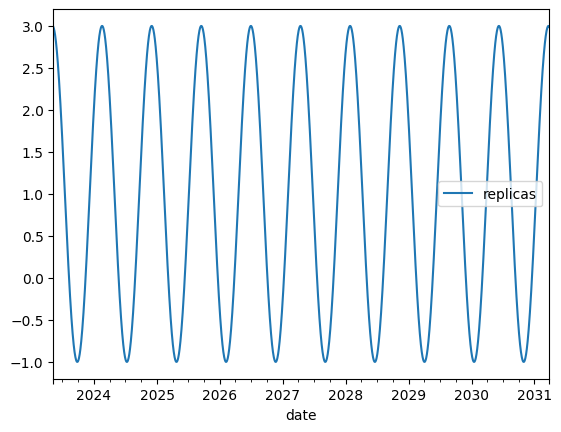

In [3]:
# Generate the base sinusoidal component
sinusodialFactor1 = SinusoidalFactor(
    feature="replicas",
    col_name="replicas_seasonal_factor1",
    feature_values={
        "replicas": {
            "wavelength": no_of_samples_per_day,
            "amplitude": 2,
            "phase": 365,
            "mean": 1
        },
    }
)
sinusodialFactor1.plot(start_date=start_date, end_date=end_date_temp)

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='date'>)

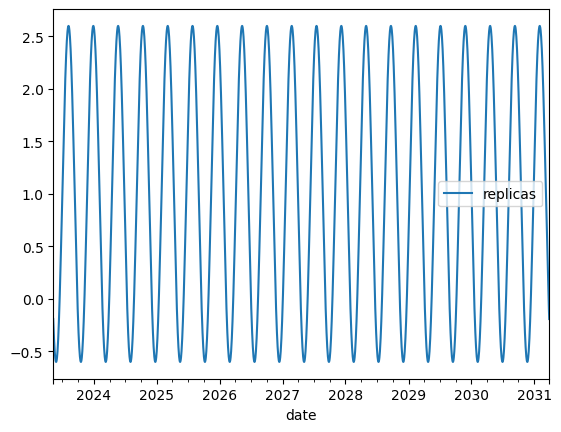

In [4]:
# Generate the overlay sinusoidal component
sinusodialFactor2 = SinusoidalFactor(
    feature="replicas",
    col_name="replicas_seasonal_factor2",
    feature_values={
        "replicas": {
            "wavelength": no_of_samples_per_day/2,
            "amplitude": 1.6,
            "phase": 365/4,
            "mean": 1
        },
    }
)
sinusodialFactor2.plot(start_date=start_date, end_date=end_date_temp)

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='date'>)

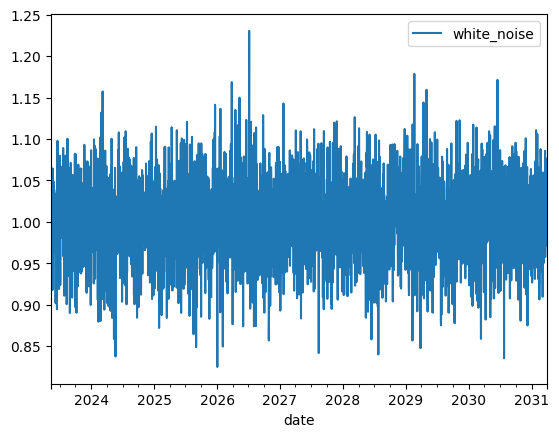

In [5]:
# Generate some noise
white_noise = WhiteNoise()
white_noise.plot(start_date=start_date, end_date=end_date_temp)

In [6]:
# Generate the dataset
features_dict = {
    "replicas": ["replicas"]
}
g: Generator = Generator(
    factors={
        sinusodialFactor1,
        sinusodialFactor2,
        white_noise
    },
    features=features_dict,
    date_range=pd.date_range(start=start_date, end=end_date_temp),
    base_value=10
)
    
df = g.generate()

<AxesSubplot:>

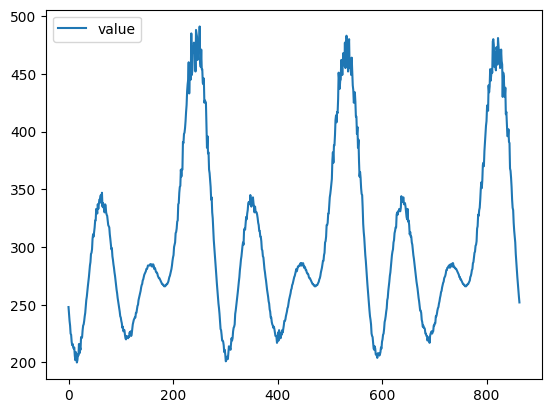

In [7]:
# Scale the features to the desired range
scaler = MinMaxScaler(feature_range=(min_replicas*throughput_per_replica, max_replicas*throughput_per_replica)) # for replicas
df['value'] = scaler.fit_transform(df[['value']]).round()
df['timestamp'] = pd.date_range(start=start_date, end=end_date, freq='{}min'.format(resolution))

df.head(no_of_samples_per_day*3).plot(y="value")

<AxesSubplot:xlabel='timestamp'>

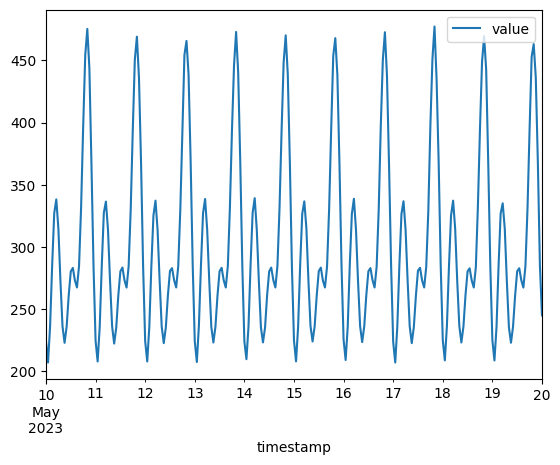

In [8]:
# Resample for simplied plotting
reSampledDF = df.resample('1H', on='timestamp').mean()
reSampledDF.plot(y='value', kind='line')

In [9]:
# Save the dataset in a csv file
df.to_csv('dataset.csv', columns=['timestamp','value'], index=False)